# Change in crossing times

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scmdata.database
import scmdata.processing
import seaborn as sns
import tqdm.autonotebook as tqdman
from matplotlib.gridspec import GridSpec

import utils
import utils.categorisation
import utils.plotting

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/nicholls-et-al-2022-emulator-changes/lib/python3.7/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["text.usetex"] = False
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.xmargin"] = 0

<IPython.core.display.Javascript object>

In [5]:
categorisations = pd.read_csv(
    os.path.join(
        utils.DATA_DIR, "processed", "categorisation", "standard_categorisation.csv"
    )
)
possible_ids = set(categorisations["id"])

categorisations = categorisations.pivot_table(
    index=["model", "scenario"],
    columns=["id"],
    values=["category"],
    aggfunc=lambda x: x,
)
categorisations.columns = categorisations.columns.map(lambda x: f"{x[1]} category")
categorisations

AR6 calibration SR1.5 processing FaIRv1.6.2 category  \
model             scenario                                                                      
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100                                         Below 1.5C     
                  ADVANCE_2020_Med2C                                               Lower 2C     
                  ADVANCE_2020_WB2C                                              Below 1.5C     
                  ADVANCE_2030_Med2C                                              Higher 2C     
                  ADVANCE_2030_Price1.5C                                 1.5C low overshoot     
...                                                                                     ...     
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                                                     Above 2C     
                  CD-LINKS_NPi2020_1000                                  1.5C low overshoot     
                  CD-LINKS_NPi2020_1600                                            Lower 2C     
                  CD-LINKS_NPi2020_400                                           Below 1.5C     
                  CD-LINKS_NoPolicy                                                Above 2C     

                                         AR6 calibration SR1.5 processing MAGICCv7.5.3 category  \
model             scenario                                                                        
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100                                 1.5C low overshoot       
                  ADVANCE_2020_Med2C                                              Higher 2C       
                  ADVANCE_2020_WB2C                                      1.5C low overshoot       
                  ADVANCE_2030_Med2C                                               Above 2C       
                  ADVANCE_2030_Price1.5C                                1.5C high overshoot       
...                                                                                     ...       
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                                                     Above 2C       
                  CD-LINKS_NPi2020_1000                                  1.5C low overshoot       
                  CD-LINKS_NPi2020_1600                                            Lower 2C       
                  CD-LINKS_NPi2020_400                                   1.5C low overshoot       
                  CD-LINKS_NoPolicy                                                Above 2C       

                                         RCMIP Phase 2 calibration SR1.5 processing MAGICCv7.5.3 category  \
model             scenario                                                                                  
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100                                         Below 1.5C                 
                  ADVANCE_2020_Med2C                                               Lower 2C                 
                  ADVANCE_2020_WB2C                                              Below 1.5C                 
                  ADVANCE_2030_Med2C                                              Higher 2C                 
                  ADVANCE_2030_Price1.5C                                1.5C high overshoot                 
...                                                                                     ...                 
WITCH-GLOBIOM 4.4 CD-LINKS_NPi                                                     Above 2C                 
                  CD-LINKS_NPi2020_1000                                          Below 1.5C                 
                  CD-LINKS_NPi2020_1600                                            Lower 2C                 
                  CD-LINKS_NPi2020_400                                           Below 1.5C                 
                  CD-LINKS_NoPolicy                                                Above 2C                 

                                         SR1.5 calibration SR1.5 processi

<IPython.core.display.Javascript object>

In [6]:
temperature_thresholds = [1.5, 2.0]
variables = ["Surface Temperature (GSAT)"]
percentile = "50.0"

db = []
for calib, dbpath, climate_model, harmonise_names in tqdman.tqdm(
    (
        ("SR1.5 calibration", os.path.join("sr15-output"), "MAGICC6", False),
        ("SR1.5 calibration", os.path.join("sr15-output"), "FaIR1.3", False),
        (
            "AR6 calibration",
            os.path.join("ar6-output", "MAGICC", utils.AR6_OUTPUT_SR15_RAW_ID),
            utils.MAGICC_VERSION,
            True,
        ),
        (
            "RCMIP Phase 2 calibration",
            os.path.join(
                "ar6-output",
                "MAGICC",
                utils.AR6_OUTPUT_SR15_RAW_RCMIP_PHASE_2_CONFIG_ID,
            ),
            utils.MAGICC_VERSION,
            True,
        ),
        (
            "AR6 calibration",
            os.path.join("ar6-output", "fair", "sr15-processing"),
            "FaIRv1.6.2",
            True,
        ),
    )
):
    climate_model_db = scmdata.database.ScmDatabase(
        os.path.join(utils.DATA_DIR, "processed", dbpath),
        levels=("variable", "percentile"),
    )

    climate_model_data = scmdata.run_append(
        [
            utils.load_with_mod_scen(
                climate_model_db,
                variable=v,
                percentile=percentile,
                harmonise_model_scenario_names=harmonise_names,
            )
            for v in variables
        ]
    )
    climate_model_data = climate_model_data.filter(climate_model=climate_model)

    methodology = climate_model_data.get_unique_meta("methodology", True)
    climate_model = climate_model_data.get_unique_meta("climate_model", True)
    idh = f"{calib} {methodology} processing {climate_model}"
    assert idh in possible_ids, idh

    climate_model_data["id"] = idh

    db.append(climate_model_data)

db = scmdata.run_append(db)
assert db.meta[["model", "scenario"]].drop_duplicates().shape[0] == 411
db

  0%|          | 0/5 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 2054, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model  \
	0                 exclude           False             False       MAGICC6   
	1                 exclude           False             False       MAGICC6   
	2                 exclude           False             False       MAGICC6   
	3                 exclude           False             False       MAGICC6   
	4                 exclude           False             False       MAGICC6   
	...                   ...             ...               ...           ...   
	2049                  NaN             NaN               NaN    FaIRv1.6.2   
	2050                  NaN             NaN               NaN    FaIRv1.6.2   
	2051                  NaN             NaN               NaN    FaIRv1.6.2   
	2052                  NaN             NaN               NaN    FaIRv1.6.2   
	2053                  

<IPython.core.display.Javascript object>

Copy the SR1.5 Table 2.4 metadata to the WG3 runs.

In [7]:
db = utils.copy_sr15_table_24_metadata_throughout(db)
db

<scmdata.ScmRun (timeseries: 2054, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model  \
	0                in range            True             False       MAGICC6   
	1                in range            True             False       FaIR1.3   
	2                in range            True             False  MAGICCv7.5.3   
	3                in range            True             False  MAGICCv7.5.3   
	4                in range            True             False    FaIRv1.6.2   
	...                   ...             ...               ...           ...   
	2049             in range            True             False       MAGICC6   
	2050             in range            True             False       FaIR1.3   
	2051             in range            True             False  MAGICCv7.5.3   
	2052             in range            True             False  MAGICCv7.5.3   
	2053             in ra

<IPython.core.display.Javascript object>

Add categorisations to database.

In [8]:
db = utils.categorisation.add_categorisation_to_scmrun(db, categorisations)
db

<scmdata.ScmRun (timeseries: 2054, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     AR6 calibration SR1.5 processing FaIRv1.6.2 category  \
	0                                            Below 1.5C     
	1                                            Below 1.5C     
	2                                            Below 1.5C     
	3                                            Below 1.5C     
	4                                            Below 1.5C     
	...                                                 ...     
	2049                                           Above 2C     
	2050                                           Above 2C     
	2051                                           Above 2C     
	2052                                           Above 2C     
	2053                                           Above 2C     
	
	     AR6 calibration SR1.5 processing MAGICCv7.5.3 category  \
	0                                    1.5C low overshoot       
	1     

<IPython.core.display.Javascript object>

## Calculate crossing times

In [9]:
def get_crossing_times(inp, threshold):
    gt_threshold = inp[inp > threshold]
    if gt_threshold.empty:
        return np.nan, np.nan

    way_up = gt_threshold.index.min()
    way_down = gt_threshold.index.max()
    assert way_up <= way_down
    if way_down == inp.index.max():
        return way_up, np.nan

    return way_up, way_down

<IPython.core.display.Javascript object>

In [10]:
crossing_times = (
    db.filter(year=range(2010, 2100 + 1))
    .timeseries(time_axis="year")
    .apply(get_crossing_times, threshold=1.5, axis=1)
    .to_frame("crossing_tuple")
)

crossing_times["way_up"] = crossing_times["crossing_tuple"].apply(lambda x: x[0])
crossing_times["way_down"] = crossing_times["crossing_tuple"].apply(lambda x: x[1])
crossing_times = crossing_times.drop("crossing_tuple", axis="columns")
crossing_times.columns.name = "direction"
crossing_times = crossing_times.stack(dropna=False).to_frame("crossing_time")
crossing_times

crossing_time
AR6 calibration SR1.5 processing FaIRv1.6.2 cat... AR6 calibration SR1.5 processing MAGICCv7.5.3 c... Kyoto-GHG|2010 (SAR) RCMIP Phase 2 calibration SR1.5 processing MAGI... SR1.5 Table 2.4 SR1.5 calibration SR1.5 processing FaIR1.3 cate... SR1.5 calibration SR1.5 processing MAGICC6 cate... aim_over_sampling climate_model id                                                 methodology model             model_scenario                      percentile region scenario               unit variable                   direction               
Below 1.5C                                         1.5C low overshoot                                 in range             Below 1.5C                                         True            Below 1.5C                                         1.5C low overshoot                                 False             MAGICC6       SR1.5 calibration SR1.5 processing MAGICC6         SR1.5       AIM/CGE 2.0       AIM/CGE 2.0-ADVANCE_2020_1.5C-2100  50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT) way_up            2036.0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  way_down          2054.0
                                                                                                                                                                                                                                                                                                                      FaIR1.3       SR1.5 calibration SR1.5 processing FaIR1.3         SR1.5       AIM/CGE 2.0       AIM/CGE 2.0-ADVANCE_2020_1.5C-2100  50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT) way_up               NaN
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  way_down             NaN
                                                                                                                                                                                                                                                                                                                      MAGICCv7.5.3  AR6 calibration SR1.5 processing MAGICCv7.5.3      SR1.5       AIM/CGE 2.0       AIM/CGE 2.0-ADVANCE_2020_1.5C-2100  50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT) way_up            2032.0
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ...
Above 2C                                           Above 2C                                           in range             Above 2C                                           True            Above 2C               

<IPython.core.display.Javascript object>

n_nans = 0


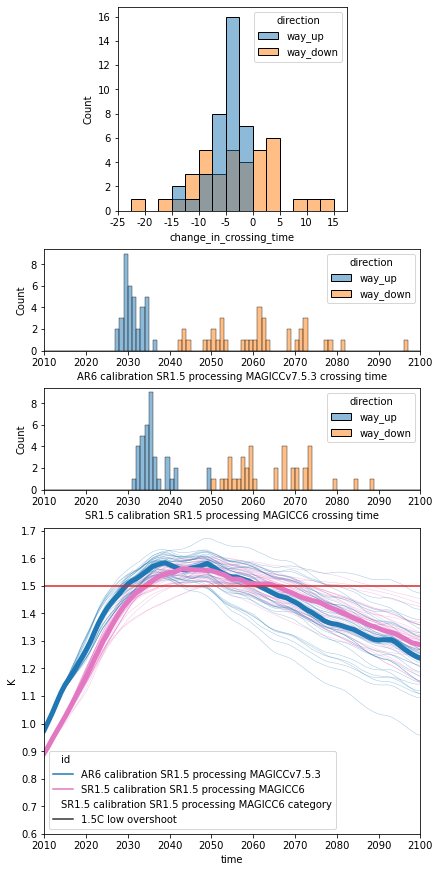

<IPython.core.display.Javascript object>

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(6, 12))
gs = GridSpec(7, 6, figure=fig)

axes = [
    fig.add_subplot(gs[0:2, 1:5]),
    fig.add_subplot(gs[2, :]),
    fig.add_subplot(gs[3, :]),
    fig.add_subplot(gs[4:, :]),
]

plt_years = range(2010, 2100 + 1)
pdf = crossing_times.reset_index()
plot_categories = [
    #             "Below 1.5C",
    "1.5C low overshoot",
    #     "1.5C high overshoot",
]
pdf = pdf[
    pdf["SR1.5 calibration SR1.5 processing MAGICC6 category"].isin(plot_categories)
    & pdf["SR1.5 Table 2.4"].isin(["True"])
]
exp_scen_no = 73
exp_scen_no = 37

ids = (
    "AR6 calibration SR1.5 processing MAGICCv7.5.3",
    "SR1.5 calibration SR1.5 processing MAGICC6",
)

diff_idx = [
    "SR1.5 calibration SR1.5 processing MAGICC6 category",
    "model",
    "scenario",
    "variable",
    "direction",
]
diff_cols = diff_idx + [
    "crossing_time",
]

pdf_0 = pdf[pdf["id"] == ids[0]][diff_cols].set_index(diff_idx)
assert pdf_0.shape[0] == exp_scen_no * 2, pdf_0.shape[0]
pdf_1 = pdf[pdf["id"] == ids[1]][diff_cols].set_index(diff_idx)
assert pdf_1.shape[0] == exp_scen_no * 2

diff = (
    (pdf_0 - pdf_1)
    .reset_index()
    .rename({"crossing_time": "change_in_crossing_time"}, axis="columns")
)
diff["diff"] = f"{ids[0]} - {ids[1]}"
# ensure nans show up on plot
n_nans = diff["change_in_crossing_time"].isnull().sum()
print(f"n_nans = {n_nans}")

if n_nans > 0:
    nan_padding = 15
    diff["change_in_crossing_time"] = diff["change_in_crossing_time"].fillna(
        diff["change_in_crossing_time"].max() + nan_padding
    )

    bins = np.arange(
        diff["change_in_crossing_time"].min().round(-1) - 5,
        diff["change_in_crossing_time"].max() + 3,
        2.5,
    )  # + 0.5
    xticks = np.arange(bins[0], bins[-1] - nan_padding, 5)

else:
    bins = np.arange(
        diff["change_in_crossing_time"].min().round(-1) - 5,
        diff["change_in_crossing_time"].max() + 5,
        2.5,
    )  # + 0.5
    xticks = np.arange(bins[0], bins[-1], 5)

sns.histplot(
    data=diff,
    x="change_in_crossing_time",
    hue="direction",
    #     hue="SR1.5 calibration SR1.5 processing MAGICC6 category",
    #     multiple="stack",
    #     multiple="dodge",
    multiple="layer",
    ax=axes[0],
    bins=bins,
    #     shrink=0.8,
    #     binwidth=0.8,
    #     rwidth=0.8,
)
axes[0].set_xticks(xticks)

for idp, ax in zip(ids, axes[1:3]):
    sns.histplot(
        data=pdf[pdf["id"] == idp],
        x="crossing_time",
        hue="direction",
        #     stat="probability",
        common_norm=False,
        bins=plt_years,
        #     kde=True,
        ax=ax,
    )
    ax.set_xlabel(f"{idp} crossing time")
    ax.set_xticks(range(plt_years[0], plt_years[-1] + 1, 10))


db_h = db.filter(
    year=plt_years,
    **{
        "SR1.5 calibration SR1.5 processing MAGICC6 category": plot_categories,
        "id": ids,
        "SR1.5 Table 2.4": "True",
    },
)
assert db_h.shape[0] == 2 * exp_scen_no
keep_meta = [
    "model",
    "scenario",
    "model_scenario",
    "id",
    "variable",
    "unit",
    "region",
    "SR1.5 calibration SR1.5 processing MAGICC6 category",
]

db_h = db_h.drop_meta(list(set(db.meta_attributes) - set(keep_meta)))
db_h_median = db_h.process_over(["model", "scenario", "model_scenario"], "median")
db_h_median["model"] = "model"
db_h_median["scenario"] = "scenario"
db_h_median["model_scenario"] = "model_scenario"
db_h_median = scmdata.ScmRun(db_h_median)

pkwargs = dict(
    hue="id",
    style="SR1.5 calibration SR1.5 processing MAGICC6 category",
    dashes=[""] * len(plot_categories),
    palette=utils.plotting.ID_COLOURS,
)
ax = db_h.lineplot(
    **pkwargs,
    units="model_scenario",
    estimator=None,
    linewidth=0.5,
    alpha=0.4,
    legend=False,
    ax=axes[3],
)

db_h_median.lineplot(**pkwargs, linewidth=5, ax=ax)

ax.set_yticks(np.arange(0.6, 1.71, 0.1))
ax.axhline(1.5, color="tab:red")

plt.savefig(
    os.path.join(utils.FIGURES_DIR, f"220_crossing-times.pdf"), transparent=True
)
# plt.tight_layout()

In [12]:
diff["change_in_crossing_time"].min()

-21.0

<IPython.core.display.Javascript object>

In [13]:
diff.groupby("direction").describe(percentiles=[0.05, 0.95])

change_in_crossing_time                                            \
                            count      mean       std   min    5%  50%  95%   
direction                                                                     
way_down                     37.0 -3.297297  7.464229 -21.0 -13.8 -4.0  8.8   
way_up                       37.0 -5.108108  3.212681 -15.0 -11.4 -5.0 -1.8   

                 
            max  
direction        
way_down   13.0  
way_up     -1.0

<IPython.core.display.Javascript object>